Exercise 1

In [1]:
%matplotlib inline
import stock_analysis
from stock_analysis.utils import group_stocks

start, end = '2019-01-01', '2020-12-31'
reader = stock_analysis.StockReader(start, end)
bitcoin = reader.get_bitcoin_data('USD')
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker)
    for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

sp = reader.get_index_data('S&P 500')

faang = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

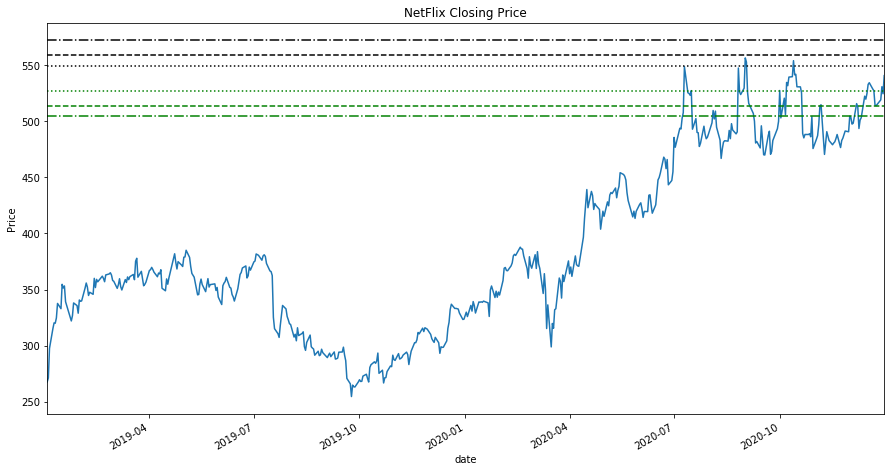

In [5]:
import itertools

def levels(analyzer, method):
    return [getattr(analyzer, method)(i) for i in range(1, 4)]

netflixanalyzer = stock_analysis.StockAnalyzer(nflx)
support_levels, resistance_levels = (
    levels(nflx_analyzer, metric) for metric in ['support', 'resistance']
)

netflixviz = stock_analysis.StockVisualizer(nflx)
ax = netflixviz.evolution_over_time('close', figsize=(15, 8), title='NetFlix Closing Price')

for support, resistance, linestyle, level in zip(
    support_levels, resistance_levels, 
    [':', '--', '-.'], itertools.count(1)
):
    netflixviz.add_reference_line(
        ax, 
        y=support, 
        label=f'support level {level}', 
        color='green', 
        linestyle=linestyle
    )
    netflixviz.add_reference_line(
        ax, 
        y=resistance, 
        label=f'resistance level {level}', 
        color='black', 
        linestyle=linestyle
    )
ax.set_ylabel('Price')
ax.get_legend().remove()


Exercise 2

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002922A0F0C08>,
      dtype=object)

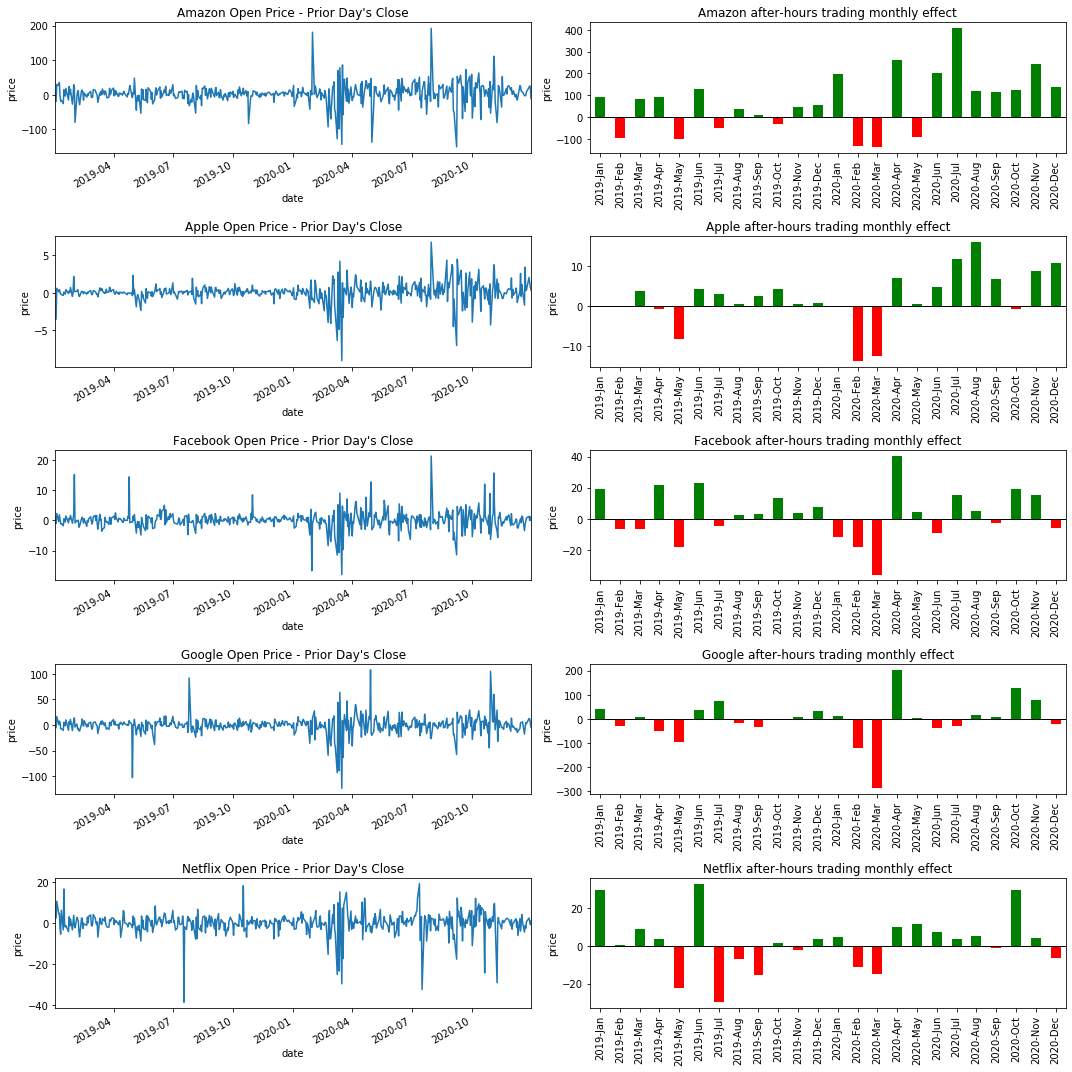

In [6]:
stock_analysis.AssetGroupVisualizer(faang).after_hours_trades()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002922B0224C8>,
      dtype=object)

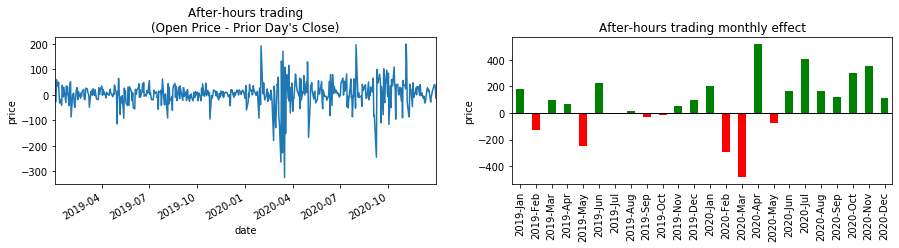

In [7]:
from stock_analysis.utils import make_portfolio

stock_analysis.StockVisualizer(make_portfolio(faang)).after_hours_trades()

Exercise 3

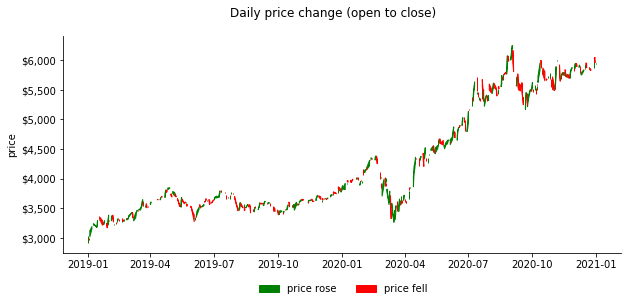

In [8]:
from matplotlib.ticker import StrMethodFormatter
from stock_analysis.utils import make_portfolio

ax = stock_analysis.StockVisualizer(make_portfolio(faang)).open_to_close()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

Exercise 4

In [9]:
fbalxdf = reader.get_ticker_data('FBALX')
msftdf = reader.get_ticker_data('MSFT')
mutual_fund = group_stocks({
    '0 - FBALX': fbalxdf,
    '1 - Microsoft': msftdf,
    '2 - Apple': aapl,
    '3 - Amazon': amzn
})
stock_analysis.AssetGroupAnalyzer(mutual_fund).analyze('annualized_volatility')

{'0 - FBALX': 0.2429878458513019,
 '1 - Microsoft': 0.4394683613426671,
 '2 - Apple': 0.4670809643500884,
 '3 - Amazon': 0.38510990770417824}

Exercise 5

In [11]:
import pandas as pd

def stock_metrics(stock, index, r_f):
    return pd.DataFrame({
        metric: getattr(
            stock_analysis.StockAnalyzer(stock), 
            metric
        )(**kwargs) \
        for metric, kwargs in {
            'alpha': {'index': index, 'r_f': r_f}, 
            'beta': {'index': index}, 
            'sharpe_ratio': {'r_f': r_f},
            'is_bear_market': {},
            'is_bull_market': {},
            'annualized_volatility': {}            
        }.items()
    }, index=range(1))

stock_metrics(amzn, sp, r_f=reader.get_risk_free_rate_of_return())

,alpha,beta,sharpe_ratio,is_bear_market,is_bull_market,annualized_volatility
0,0.738339,0.756369,3.072867,False,False,0.38511


Exercise 6

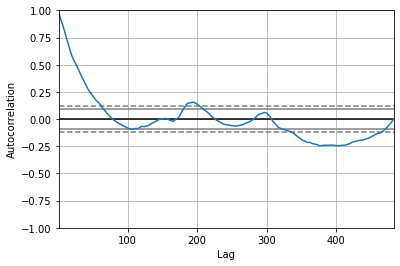

In [12]:
trainmodel, testmodel = sp['2019':'2020-11'], sp.loc['2020-12']
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(trainmodel.close)

In [13]:
%%capture
from stock_analysis import StockModeler
arimamodel = StockModeler.arima(trainmodel, ar=15, i=1, ma=5)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002922AD338C8>,
      dtype=object)

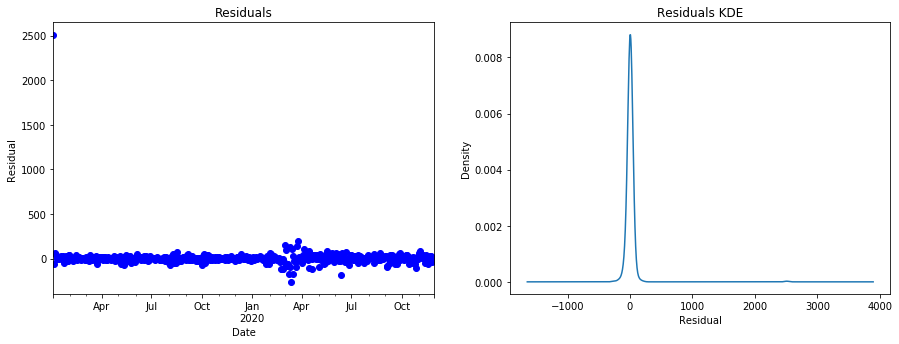

In [14]:
StockModeler.plot_residuals(arimamodel)

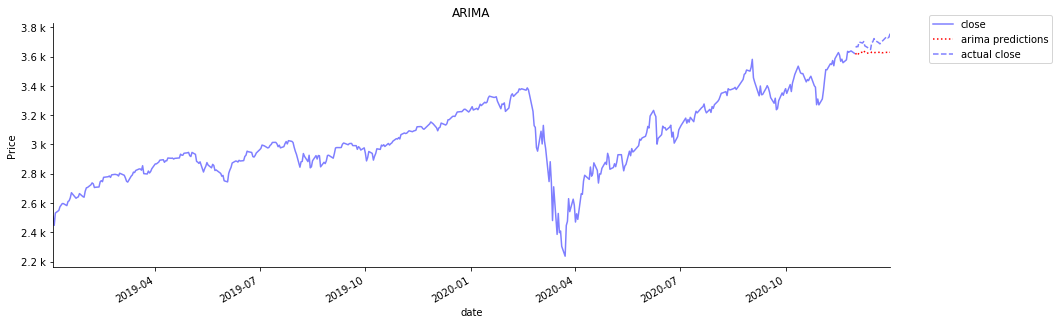

In [17]:
from matplotlib.ticker import EngFormatter

dates = testmodel.index

arimaax = StockModeler.arima_predictions(
    trainmodel, arimamodel, start=dates[0], end=dates[-1],
    title='ARIMA', color='b', figsize=(15, 5), alpha=0.5
)
testmodel.close.plot(ax=arimaax, style='b--', label='actual close', alpha=0.5)
arimaax.set_ylabel('Price')
arimaax.yaxis.set_major_formatter(EngFormatter())
arimaax.legend(bbox_to_anchor=(1.2, 1.05))


for spine in ['top', 'right']:
    arimaax.spines[spine].set_visible(False)

Exercise 7

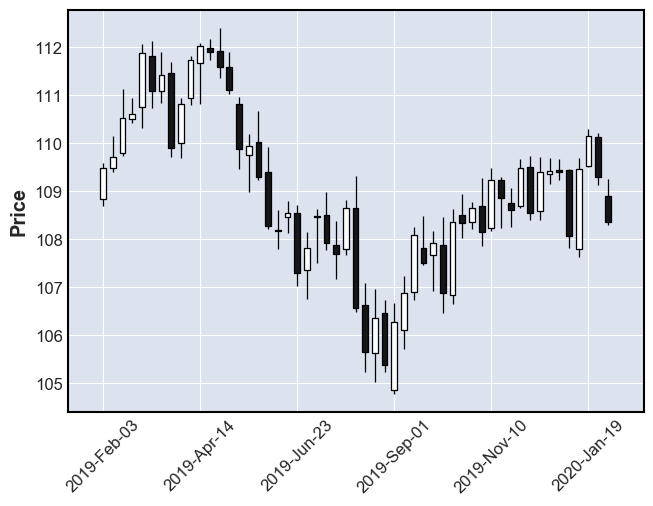

In [18]:
fxrates = reader.get_forex_rates('USD', 'JPY', api_key='UJDXRD8BZBWIB30F')
stock_analysis.StockVisualizer(fxrates).candlestick(date_range=slice('2019-02-01', '2020-01-31'), resample='1W')